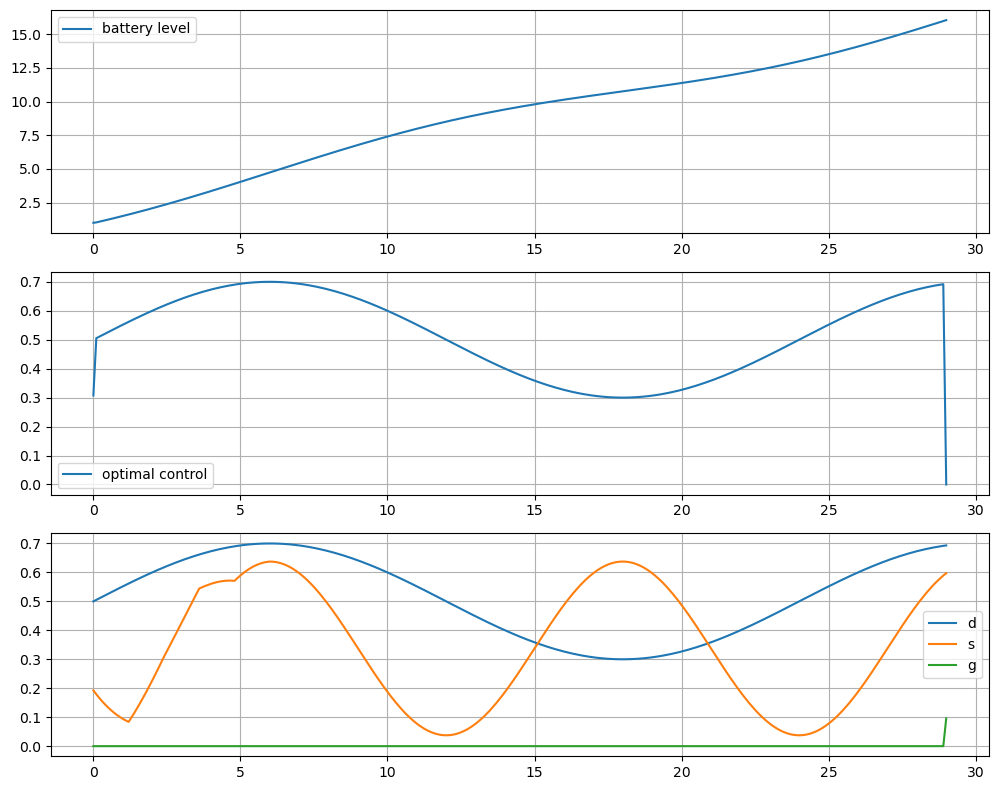

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

penalty = 1e99
def w(x, B_max):
    if x > B_max:
        return penalty
    elif x < 0:
        return penalty
    else:
        return 0

def dwdx(x, B_max):
    epsilon = 0.1
    if abs(x - B_max) < epsilon or abs(x) < epsilon:
        return penalty  
    else:
        return 0

def g(d, s, u):
    return max(d - s - u, 0)

def optimal_control(p, x, s, d, u_prev, B_max):

    if g(d, s, u_prev) > 0:
        dHdu = p - w(x, B_max) + 1
    else:
        dHdu = p - w(x, B_max)

    if dHdu > 0:
        u = max(d-s, 0)
    elif dHdu < 0:
        u = min(d, x)
    else:
        u = 0

    return u

def solve_pmp(s, d, B_max, x_0, t_0, t_f, dt):
    
    time = np.arange(t_0, t_f + dt, dt)
    n_steps = len(time)
    x = np.zeros(n_steps)
    p = np.zeros(n_steps)
    u = np.zeros(n_steps)

    x[0] = x_0
    p[-1] = 0  

    for i in range(n_steps - 1):
        u[i] = optimal_control(p[i], x[i], s[i], d[i], u[i - 1] if i > 0 else 0, B_max)
        x[i + 1] = x[i] + u[i] * dt
        p[i] = p[i+1] + dwdx(x[i], B_max) * u[i] * dt


    return time, x, u, p


t_0 = 0
t_f = 29
dt = 0.1
B_max = 1.0
x_0 = B_max  

time = np.arange(t_0, t_f + dt, dt)
d = 0.5 + 0.2 * np.sin(2 * np.pi * time / 24)
wind = np.random.uniform(0, 0.2, 6)
wind = np.interp(time, np.linspace(0, 6, len(wind)), wind)
s = 0.3 + 0.3 * np.sin(2 * np.pi * (time / 12) - np.pi / 2) + wind


time, x, u, p = solve_pmp(s, d, B_max, x_0, t_0, t_f, dt)


plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(time, x, label='battery level')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, u, label='optimal control')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, d, label='d')
plt.plot(time, s, label='s')
plt.plot(time, np.vectorize(g)(d, s, u), label='g')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()